In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [3]:
import numpy as np
import pmcx
from matplotlib import pyplot as plt
import os
import io
from pathlib import Path
import data_loader
from scipy import interpolate
from tqdm import tqdm
import config


In [4]:
config.dataset_dir

In [ ]:
config.pl_dir

In [5]:
lower_wavelength = 450
upper_wavelength = 999 # both inclusive
loader = data_loader.DataLoader(config.dataset_dir, lower_wavelength, upper_wavelength)
# absorption spectra for HbO2, Hbb, oxCCO, redCCO, water and fat
absorption_spectra = loader.absorption_coefs(
    use_diff_oxycco = False,
    use_water_and_fat = True
)

In [6]:
wavelength_step = 25
wavelengths_sparse = np.arange(lower_wavelength, upper_wavelength, wavelength_step)
if wavelengths_sparse[-1] != upper_wavelength:
    wavelengths_sparse = np.append(wavelengths_sparse, upper_wavelength)
print(wavelengths_sparse)
print(len(wavelengths_sparse))
wavelengths_dense = loader.wavelengths

[450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875
 900 925 950 975 999]
23


In [7]:
loader_mcs = data_loader.DataLoader(None, 450, 999)
mu_a_matrix = loader_mcs.absorption_coefs(use_diff_oxycco=False, use_water_and_fat=True)

### Compute pathlength for gray matter

In [8]:
g_gm = 0.85
refractive_idx_gm = 1.36
mu_a_vector_gm = mu_a_matrix @ loader_mcs.params_ref_gray_matter[:6] / 10 # MMX takes mu_a in 1/mm
mu_a_func_gm = lambda wl: mu_a_vector_gm[np.array(wl).astype(int) - loader_mcs.wavelength_left_cut]
mu_s_red_func_gm = lambda wl: loader_mcs.params_ref_gray_matter[-2] * np.power((wl/500), -loader_mcs.params_ref_gray_matter[-1]) / 10
mu_s_func_gm = lambda wl: mu_s_red_func_gm(wl) / (1 - g_gm)

In [9]:
prop_mcs = np.array([[0,0,1,1],[0,0,g_gm,refractive_idx_gm]])

cfg = {
    "nphoton": 1e7,
    "maxdetphoton": 1e7,
    "vol": np.ones((100, 100, 120), dtype="uint8"),
    "tstart":0,
    "tend":5e-9,
    "tstep":5e-9,
    "autopilot": 1,
    "gpuid": 1,
    "prop": np.array([[0,0,1,1],[0,0,1,1]]),
    "bc": "ccrcca001000",
    "isspecular": 1, # should not have effect without 0-voxels
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [60, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, 60, 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dpx",
    "flog": str(config.pl_dir) + "/log.txt"
}

In [12]:
# empty log file
open(config.pl_dir / "log.txt", "w").close()
header_sim = "wavelength mu_a mu_s diffuse-reflectance pathlength"
with open(config.pl_dir / "gray_matter_mcs.txt", "w") as f:
    f.write("# " + header_sim + "\n")

data_gray_matter_mcs = np.empty((len(wavelengths_sparse), 5), dtype="float") # per wavelength: wavelength, mu_a, mu_s (1/mm), diffuse reflectance, pathlength (mm)

for i, wl in enumerate(wavelengths_sparse):
    print(f"Simulating for {wl}nm...")
    mu_a = mu_a_func_gm(wl)
    mu_s = mu_s_func_gm(wl)
    cfg["prop"][1, 0] = mu_a
    cfg["prop"][1, 1] = mu_s
    cfg["prop"][1, 2] = g_gm
    cfg["prop"][1, 3] = refractive_idx_gm

    res = pmcx.mcxlab(cfg)

    detw = pmcx.utils.detweight(res["detp"])
    dref = np.sum(detw) / cfg["nphoton"]
    pl = pmcx.utils.meanpath(res["detp"])[0]
    data_gray_matter_mcs[i, :] = np.array([wl, mu_a, mu_s, dref, pl])

    with open(config.pl_dir / "gray_matter_mcs.txt", "ab") as f:
        np.savetxt(f, data_gray_matter_mcs[[i]])


Simulating for 450nm...
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1


KeyboardInterrupt: 

Interpolate

In [10]:
assert(np.all(np.diff(wavelengths_dense) > 0))
pl_gm_interpolated_linear = np.interp(wavelengths_dense, wavelengths_sparse, data_gray_matter_mcs[:, 4])
pl_gm_spline_coefs = interpolate.splrep(wavelengths_sparse, data_gray_matter_mcs[:, 4])
pl_gm_interpolated_spline = interpolate.splev(wavelengths_dense, pl_gm_spline_coefs)

Plot pathlength

In [21]:
# Optional load values from file
data_gray_matter_mcs = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
pl_gm_interpolated_linear = np.loadtxt(config.pl_dir / "gray_matter_pl_interpolated_linear.txt")[:, 1]
pl_gm_interpolated_spline = np.loadtxt(config.pl_dir / "gray_matter_pl_interpolated_spline.txt")[:, 1]

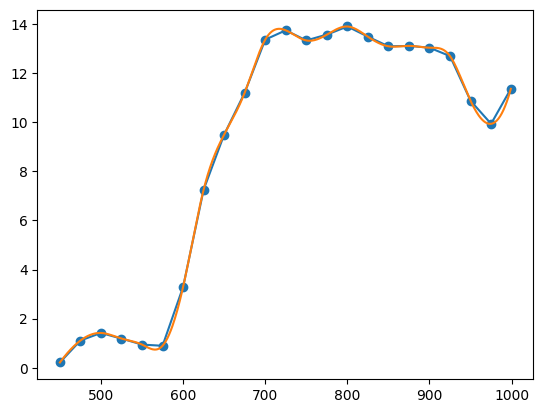

In [17]:
plt.scatter(wavelengths_sparse, data_gray_matter_mcs[:, -1])
plt.plot(wavelengths_dense, pl_gm_interpolated_linear)
plt.plot(wavelengths_dense, pl_gm_interpolated_spline)

Save data to file

In [12]:
header_interpolations = "wavelength pathlength"

np.savetxt(
    config.pl_dir / "gray_matter_pl_interpolated_linear.txt",
    np.row_stack((wavelengths_dense, pl_gm_interpolated_linear)).T,
    header=header_interpolations
)

np.savetxt(
    config.pl_dir / "gray_matter_pl_interpolated_spline.txt",
    np.row_stack((wavelengths_dense, pl_gm_interpolated_spline)).T,
    header=header_interpolations
)

### Compute pathlength for blood vessels

In [9]:
g_bv = 0.935
refractive_idx_bv = 1.4
mu_a_vector_bv = mu_a_matrix @ loader_mcs.params_ref_blood_vessel[:6] / 10 # MMX takes mu_a in 1/mm
mu_a_func_bv = lambda wl: mu_a_vector_bv[np.array(wl).astype(int) - loader_mcs.wavelength_left_cut]
mu_s_red_func_bv = lambda wl: loader_mcs.params_ref_blood_vessel[-2] * np.power((wl/500), -loader_mcs.params_ref_blood_vessel[-1]) / 10
mu_s_func_bv = lambda wl: mu_s_red_func_bv(wl) / (1 - g_bv)

In [10]:
bv_thickness = 0.1 #[mm], = voxel size
tissue_depth = 80 #[mm]
tissue_width = 40 #[mm]

In [11]:
n_voxels_width = int(tissue_width / bv_thickness)
n_voxels_depth = int(tissue_depth / bv_thickness)
print(f"Simulating with {n_voxels_width}^2 x {n_voxels_depth} = {n_voxels_depth * (n_voxels_width**2)} voxels.")

prop = np.array([[0,0,1,1],[0,0,g_gm,refractive_idx_gm],[0,0,g_bv,refractive_idx_bv]])

cfg = {
    "nphoton": 5e7, # higher spatial resolution needs more photons for same noise level
    "maxdetphoton": 5e7,
    "tstart":0,
    "tend":5e-9,
    "tstep":5e-9,
    "autopilot": 1,
    "gpuid": 1,
    "prop": prop,
    "unitinmm": bv_thickness,
    "bc": "ccrcca001000",
    "isspecular": 1, # should not have effect without 0-voxels
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [n_voxels_width, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, n_voxels_width, 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dpx",
    "flog": str(config.pl_dir) + "/log.txt"
}


cfg["vol"] = np.ones((n_voxels_width, n_voxels_width, n_voxels_depth), dtype="uint8")
# first layer is blood vessel
cfg["vol"][:, :, 0] = 2

Simulating with 400^2 x 800 = 128000000 voxels.


In [ ]:
# empty log file
open(config.pl_dir / "log.txt", "w").close()
header_sim = "wavelength gray-matter-mu_a gray-matter-mu_s blood-vessel-mu_a blood-vessel-mu_s diffuse-reflectance gray-matter-pathlength blood-vessel-pathlength total-pl"
with open(config.pl_dir / "blood_vessel_mcs.txt", "w") as f:
    f.write("# " + header_sim + "\n")

data_blood_vessel_mcs = np.empty((len(wavelengths_sparse), 9), dtype="float") # per wavelength: wavelength, mu_a, mu_s (1/mm), diffuse reflectance, pathlength (mm)

for i, wl in enumerate(wavelengths_sparse):
    print(f"Simulating for {wl}nm...")
    mu_a_gm = mu_a_func_gm(wl)
    mu_s_gm = mu_s_func_gm(wl)
    mu_a_bv = mu_a_func_bv(wl)
    mu_s_bv = mu_s_func_bv(wl)
    cfg["prop"][1, 0] = mu_a_gm
    cfg["prop"][1, 1] = mu_s_gm
    cfg["prop"][1, 2] = g_gm
    cfg["prop"][1, 3] = refractive_idx_gm
    cfg["prop"][2, 0] = mu_a_bv
    cfg["prop"][2, 1] = mu_s_bv
    cfg["prop"][2, 2] = g_bv
    cfg["prop"][2, 3] = refractive_idx_bv
    
    res = pmcx.mcxlab(cfg)

    detw = pmcx.utils.detweight(res["detp"])
    dref = np.sum(detw) / cfg["nphoton"]
    pl = pmcx.utils.meanpath(res["detp"])
    data_blood_vessel_mcs[i, :] = np.array([wl, mu_a_gm, mu_s_gm, mu_a_bv, mu_s_bv, dref, pl[0], pl[1], pl[0] + pl[1]])

    with open(config.pl_dir / "blood_vessel_mcs.txt", "ab") as f:
        np.savetxt(f, data_blood_vessel_mcs[[i]])


Simulating for 450nm...
nphoton: 5e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 5e+07
issrcfrom0: 1
autopilot: 1
unitinmm: 0.1
isspecular: 1


ValueError: could not broadcast input array from shape (8,) into shape (9,)

Interpolate

In [12]:
wavelengths_dense = loader.wavelengths
assert(np.all(np.diff(wavelengths_dense) > 0))
pl_bv_interpolated_linear = np.interp(wavelengths_dense, wavelengths_sparse, data_blood_vessel_mcs[:, -1])
pl_bv_spline_coefs = interpolate.splrep(wavelengths_sparse, data_blood_vessel_mcs[:, -1])
pl_bv_interpolated_spline = interpolate.splev(wavelengths_dense, pl_bv_spline_coefs)

NameError: name 'bv_mc_data' is not defined

Plot pathlengths

In [22]:
# Optional load values from file
data_blood_vessel_mcs = np.loadtxt(config.pl_dir / "blood_vessel_mcs.txt")
pl_bv_interpolated_linear = np.loadtxt(config.pl_dir / "blood_vessel_pl_interpolated_linear.txt")[:, 1]
pl_bv_interpolated_spline = np.loadtxt(config.pl_dir / "blood_vessel_pl_interpolated_spline.txt")[:, 1]

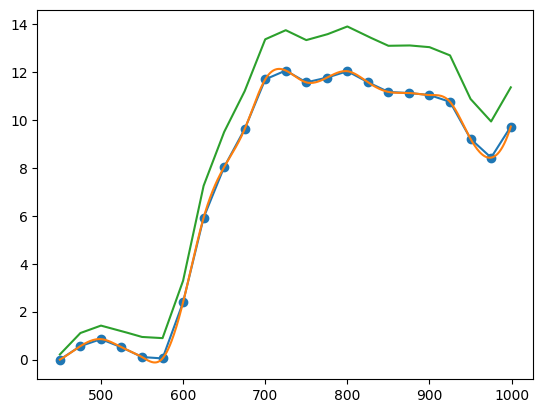

In [23]:
plt.scatter(wavelengths_sparse, data_blood_vessel_mcs[:, -1])
plt.plot(wavelengths_dense, pl_bv_interpolated_linear)
plt.plot(wavelengths_dense, pl_bv_interpolated_spline)
plt.plot(wavelengths_dense, pl_gm_interpolated_linear)

Save data to file

In [21]:
header_interpolations = "wavelength pathlength"

np.savetxt(
    config.pl_dir / "blood_vessel_pl_interpolated_linear.txt",
    np.row_stack((wavelengths_dense, pl_bv_interpolated_linear)).T,
    header=header_interpolations
)

np.savetxt(
    config.pl_dir / "blood_vessel_pl_interpolated_spline.txt",
    np.row_stack((wavelengths_dense, pl_bv_interpolated_spline)).T,
    header=header_interpolations
)

### Compute Pathlengths for Tissue with Blood Vessels in Grid Structure (unused, unfinished)

In [51]:
bv_thickness = 0.1 #[mm], = voxel simulation
bv_area_percentage = 0.0725
tissue_depth = 60 #[mm]
min_total_width = 30 #[mm]
detector_distance = 50 #[mm]

# Find the smallest surface that is evenly divided by grid,
# such that grid has area within desired interval

found = False
for n_voxels_width in range(int(min_total_width / bv_thickness), int(total_depth / bv_thickness + 1)):
    for n_vessels in range(1, int(0.5*(n_voxels_width - 1))):
        if (n_voxels_width - n_vessels) % (n_vessels + 1) != 0:
            continue
        bv_area = 2 * n_vessels * n_voxels_width - n_vessels**2
        cur_bv_area_percentage = bv_area / n_voxels_width**2
        if cur_bv_area_percentage > bv_area_percentage * 1.03:
            break
        if cur_bv_area_percentage > bv_area_percentage * 0.97:
            found = True
            break
        
    if found:
        break
        

if found:
    print(f"Total width [mm]: {n_voxels_width * bv_thickness}")
    print(f"Number of voxels: {n_voxels_width}")
    print(f"Number of vessels (per x/y-dimension, not total): {n_vessels}")
    print(f"Resulting blood vessel area percentage: {cur_bv_area_percentage}")
else:
    print("No value found")

Total width [mm]: 32.4
Number of voxels: 324
Number of vessels (per x/y-dimension, not total): 12
Resulting blood vessel area percentage: 0.07270233196159122


In [63]:
cfg = {
    "nphoton": 5e7, # higher spatial resolution needs more photons for same noise level
    "maxdetphoton": 5e7,
    "tstart":0,
    "tend":5e-9,
    "tstep":5e-9,
    "autopilot": 1,
    "gpuid": 1,
    "prop": np.array([[0,0,1,1],[0,0,1,1],[0,0,1,1]]),
    "unitinmm": bv_thickness,
    "bc": "ccrcca001000",
    "isspecular": 1, # should not have effect without 0-voxels
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [n_voxels_width, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, n_voxels_width, 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dpx",
    "flog": str(tissue_data_path) + "/log.txt"
}


cfg["vol"] = np.ones((n_voxels_width, n_voxels_width, int((tissue_depth + detector_distance)  / bv_thickness)), dtype="uint8")

# first layer is grid of blood vessels
bv_layer_z_idx = int(np.ceil(detector_distance/bv_thickness))
spacing = int((n_voxels_width - n_vessels) / (n_vessels + 1))
vessel_idxs = list(range(spacing, n_voxels_width, spacing + 1))
bv_pattern = np.zeros((n_voxels_width, n_voxels_width), dtype="bool")
bv_pattern[vessel_idxs, :] = True
bv_pattern[:, vessel_idxs] = True
cfg["vol"][:, :, bv_layer_z_idx:] = 1
cfg["vol"][bv_pattern, bv_layer_z_idx] = 2

In [64]:
# Find photon (indices) which left bounding box above blood vessels
def split_photon_idxs_by_pattern(detp, pattern):
    photon_pos = np.floor(det["p"][:, :2]).astype(int)
    in_idxs, out_idxs = []
    
    for photon_id in range(detp["detid"].shape[0]):
        x, y = photon_pos[photon_id]
        if bv_pattern[x, y]:
            in_idxs.append(photon_id)
        else:
            out_idxs.append(photon_id)
    
    return in_idxs, out_idxs

# compute weight and mean pathlength of these photons
def compute_weight_idxs(detp, prop, unitinmm, idxs):
    weight = np.ones(len(idxs))

    for i in range(np.array(prop).shape[0]):
        weight = weight * np.exp(-prop[i + 1, 0] * detp["ppath"][idxs, i]) * unitinmm
    
    return weight

def compute_meanpath_idxs(detp, prop, unitinmm, idxs):
    weight = compute_weight_idxs(detp, prop, unitinmm, idxs)
    avgpath = np.sum(
        detp["ppath"][idxs, :] * unitinmm * np.tile(weight, (detp["ppath"].shape[1], 1)).T
    ) / np.sum(weight)

    return avgpath


In [ ]:
# empty log file
open(tissue_data_path / "log.txt", "w").close()

bv_grid_mc_data = np.empty((len(wavelengths_sparse), 2), dtype="float") # per wavelength: wavelength, pathlength (mm)
gm_grid_mc_data = np.empty((len(wavelengths_sparse), 2), dtype="float") # per wavelength: wavelength, pathlength (mm)

for i, wl in enumerate(wavelengths_sparse):
    print(f"Simulating for {wl}nm...")
    mu_a_gm = mu_a_gm_matrix[wl - lower_wavelength]
    mu_s_gm = mu_s_gm_func(wl)
    mu_a_bv = mu_a_bv_matrix[wl - lower_wavelength]
    mu_s_bv = mu_s_bv_func(wl)
    cfg["prop"][1] = np.array([mu_a_gm, mu_s_gm, g_gm, refractive_idx_gm])
    cfg["prop"][2] = np.array([mu_a_bv, mu_s_bv, g_bv, refractive_idx_bv])
    
    res = pmcx.mcxlab(cfg)

    bv_photon_idxs, gm_photon_idxs = split_photon_idxs_by_pattern(res["detp"], bv_pattern)
    bv_meanpath = compute_meanpath_idxs(res["detp"], cfg["prop"], bv_thickness, bv_photon_idxs)
    gm_meanpath = compute_meanpath_idxs(res["detp"], cfg["prop"], bv_thickness, gm_photon_idxs)

    bv_grid_mc_data[i, :] = np.array([wl, bv_meanpath])
    gm_grid_mc_data = np.array([wl, gm_meanpath])